In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import cvxpy as cp
import random
from IPython.display import display
import time
import os
from joblib import Parallel, delayed


from src.model import Nonneg_dagma, MetMulDagma, BarrierDagma
import src.utils as utils

from colide.model import colide_ev


SEED = 10
N_CPUS = os.cpu_count() // 2

np.random.seed(SEED)
random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_exps(g, data_p, exps, thr=.2, verb=False):
    A_true, _, X = utils.simulate_sem(**data_p)
    A_true_bin = utils.to_bin(A_true, thr)
    X_norm = X/la.norm(X, axis=1, keepdims=True)

    M, N = X.shape

    fidelity = 1/data_p['n_samples']*la.norm(X - X @ A_true, 'fro')**2
    fidelity_norm = 1/data_p['n_samples']*la.norm(X_norm - X_norm @ A_true, 'fro')**2

    print(f'{g}: Fidelity: {fidelity:.3f}  -  Fidelity (norm): {fidelity_norm:.3f}')

    shd, fscore, err, acyc, runtime = [np.zeros(len(exps))  for _ in range(5)]
    for i, exp in enumerate(exps):
        X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X

        args = exp['args'].copy()
        if 'fix_lamb' in exp.keys() and not exp['fix_lamb']:
            args['lamb'] = get_lamb_value(N, M, args['lamb'])

        model = exp['model']()
        t_i = time.time()
        A_est = model.fit(X_aux, **args)
        t_solved = time.time() - t_i

        A_est = model.W_est

        A_est_bin = utils.to_bin(A_est, thr)
        shd[i], _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
        fscore[i] = f1_score(A_true_bin.flatten(), A_est_bin.flatten())
        err[i] = utils.compute_norm_sq_err(A_true, A_est)
        acyc[i] = model.dagness(A_est) if hasattr(model, 'dagness') else 1
        runtime[i] = t_solved

        if verb:
            print(f'\t-{exp["leg"]}: shd {shd[i]}  -  err: {err[i]:.3f}  -  time: {runtime[i]:.3f}')

    return shd, fscore, err, acyc, runtime

def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def compute_errsW(W_seq, W_true):
    errs = np.zeros(len(W_seq))
    norm_W_true = la.norm(W_true)
    for i, W_est in enumerate(W_seq):
        errs[i] = (la.norm(W_true - W_est)/norm_W_true)**2
    
    return errs
    
def plot_result(A_true, A_est, thr, plot_matrices=True):
    A_est_bin = utils.to_bin(A_est, thr)
    A_true_bin = utils.to_bin(A_true, thr)

    fro_err = utils.compute_norm_sq_err(A_true, A_est)
    fro_err_bin = utils.compute_norm_sq_err(A_true_bin, A_est_bin)
    sdh, _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
    fscore = f1_score(A_true_bin.flatten(), A_est_bin.flatten())

    print(f'Err: {fro_err:.3f}  -  Err bin: {fro_err_bin:.3f}  -  shd: {sdh}  -  fscore: {fscore:.3f}')

    if plot_matrices:
        plt.figure(figsize=(8, 8))
        plt.subplot(2,2,1)
        plt.imshow(A_true)
        plt.colorbar()
        plt.title("A true")
        plt.subplot(2,2,2)
        plt.imshow(A_est)
        plt.colorbar()
        plt.title("A est")
        plt.subplot(2,2,3)
        plt.imshow(A_true_bin)
        plt.colorbar()
        plt.title("A true bin")
        plt.subplot(2,2,4)
        plt.imshow(A_est_bin)
        plt.colorbar()
        plt.title("A est bin")

def plot_convergence(model, W_true):

    errs_W = compute_errsW(model.seq_W, W_true)

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(model.diff)
    plt.title('Convergence of W')
    plt.subplot(1,3,2)
    plt.semilogy(errs_W)
    plt.title('Error')
    plt.subplot(1,3,3)
    plt.semilogy(model.acyclicity)
    plt.title('Acyclicity')
    plt.tight_layout()

## Quick comparisons

In [3]:
# DAG parameters
N = 100
g_type = 'er'
edges = N*4
edge_type = 'positive'  # Options: binary, positive, weighted
w_range = (.5, 1)  #(.3, .9)
norm_x = False
M = 500
variance = 1 # 1/np.sqrt(N)

A, dag, X = utils.simulate_sem(N, M, g_type, edges, permute=False, edge_type=edge_type,
                               w_range=w_range, noise_type='normal', var=variance)

if norm_x:
    X = X/la.norm(X, axis=1, keepdims=True)

print(X.shape)

print(f'Mean degree: {(A.sum(axis=0).mean()):2f}')
print('Mean norm of X:', la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)


(500, 100)
Mean degree: 2.837479
Mean norm of X: 130.7537940705763
Fidelity error: 99.89188115490819


### Proj Grad Descent DAGMA Alg

Mean est value: 0.029610974274902658
Err: 0.121  -  Err bin: 0.091  -  shd: 35  -  fscore: 0.954


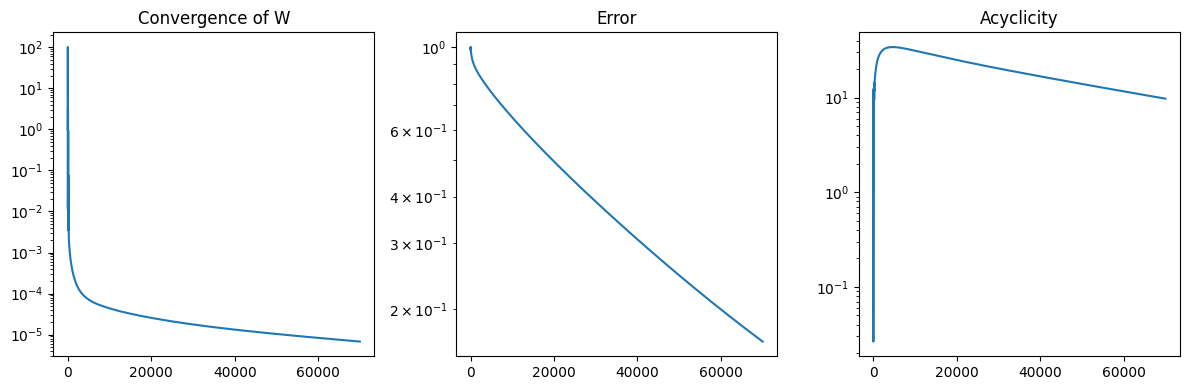

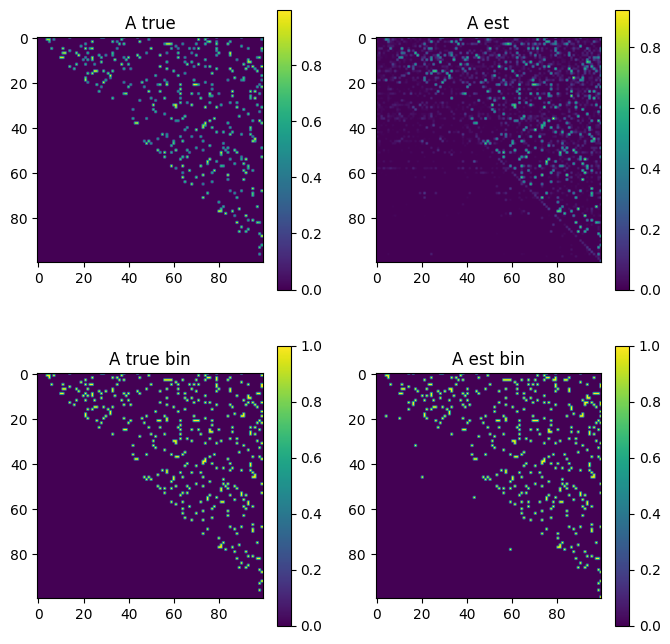

In [9]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 5e-2)
# if edges == 2*N:   
#     args = {'stepsize': 5e-2, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#             'tol': 1e-6,}
# else:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 1e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 10000,
#             'tol': 1e-6,}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#         'tol': 1e-6,}
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 1e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 70000,
        'tol': 1e-6,}



# print('lamb:', args['lamb'])

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

Mean est value: 0.029610974274902658
Err: 0.121  -  Err bin: 0.091  -  shd: 35  -  fscore: 0.954


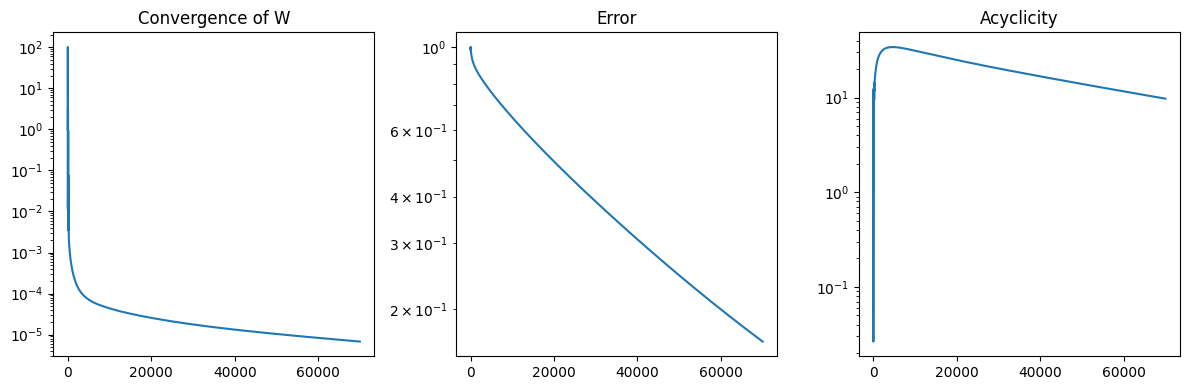

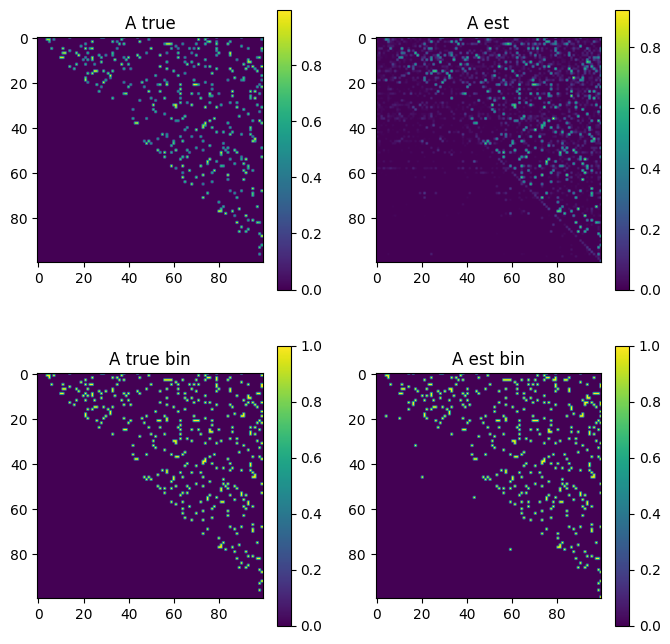

In [ ]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 5e-2)
# if edges == 2*N:   
#     args = {'stepsize': 5e-2, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#             'tol': 1e-6,}
# else:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 1e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 10000,
#             'tol': 1e-6,}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#         'tol': 1e-6,}
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 1e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 70000,
        'tol': 1e-6, 'adam_opt': True}



# print('lamb:', args['lamb'])

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### Method of Multipliers DAGMA Alg

In [11]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 2e-2)
# 2N LINKS
# if edges == 2*N:
#     args = {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}
#         # args = {'stepsize': 1e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#         #     'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}
# else:
# # 4N LINKS
#     lamb = get_lamb_value(N, M, 2e-2)
#     args = {'stepsize': 1e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 30000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}

lamb = get_lamb_value(N, M, 5e-3)
# args = {'stepsize': 2.5e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-4, 'iters_in': 30000,
#             'iters_out': 20, 'tol': 1e-6, 'beta': 2, 'dec_step': None, 'verb': True}
args = {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-4, 'iters_in': 30000,
            'iters_out': 20, 'tol': 1e-6, 'beta': 2, 'dec_step': None, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma()
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A)
plot_result(A, A_est, thr)

lamb: 0.00047985259121880814
- 1/20. Diff: 0.000016 | Acycl: 12.232415 | Rho: 0.100 - Alpha: 1.233 - Step: 0.0001


### Logarithmic barrier DAGMA Alg

In [6]:
# ## Second set of hyperparams N = 50

# lamb = get_lamb_value(N, M, 2e-2)
# print('lamb:', lamb)
# if norm_x:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 5e-1, 'alpha': 5e-3, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': .5, 'verb': True}
# else:
#     lamb = get_lamb_value(N, M, 2e-2)
#     args = {'stepsize': 2e-2, 'alpha': .01, 's': 1, 'lamb': lamb, 'iters_in': 100,
#             'iters_out': 100, 'tol': 1e-6, 'beta': .9, 'verb': True}


# t_i = time.time()
# model = BarrierDagma()
# A_est = model.fit(X, **args, track_seq=True)
# t_solved = time.time() - t_i
# print(f'Solved in {t_solved:3f} seconds')

# # Plot description
# thr = .2
# plot_convergence(model, A)
# plot_result(A, A_est, thr)

## Comparing methods - 2N Edges

In [7]:
Exps = [
    # Not norm
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 2e-2, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'fix_lamb': False, 'leg': 'PGD'},

    {'model': MetMulDagma, 'args': {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 2e-2,
     'iters_in': 5000, 'iters_out': 10, 'beta': 5, 'dec_step': False}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult'},

    {'model': MetMulDagma, 'args': {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .01,
     'iters_in': 5000, 'iters_out': 10, 'beta': 5, 'dec_step': False}, 'norm_x': False, 'fix_lamb': True,
     'leg': 'Mult-Fix'},

    # Colide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

]

### 50 nodes and 2N edges

In [8]:
###  500 samples - 50 nodes #####
N = 50

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 200, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3f} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32


2: Fidelity: 6.958  -  Fidelity (norm): 0.222
9: Fidelity: 7.124  -  Fidelity (norm): 0.394
15: Fidelity: 6.979  -  Fidelity (norm): 0.328
21: Fidelity: 7.131  -  Fidelity (norm): 0.334
1: Fidelity: 7.052  -  Fidelity (norm): 0.298
24: Fidelity: 7.004  -  Fidelity (norm): 0.313
23: Fidelity: 6.992  -  Fidelity (norm): 0.252
12: Fidelity: 6.924  -  Fidelity (norm): 0.310
16: Fidelity: 7.223  -  Fidelity (norm): 0.291
3: Fidelity: 7.077  -  Fidelity (norm): 0.348
19: Fidelity: 7.054  -  Fidelity (norm): 0.271
14: Fidelity: 6.936  -  Fidelity (norm): 0.268
6: Fidelity: 7.163  -  Fidelity (norm): 0.195
17: Fidelity: 7.003  -  Fidelity (norm): 0.207
18: Fidelity: 7.078  -  Fidelity (norm): 0.274
5: Fidelity: 7.027  -  Fidelity (norm): 0.339
8: Fidelity: 7.045  -  Fidelity (norm): 0.325
13: Fidelity: 7.199  -  Fidelity (norm): 0.303
10: Fidelity: 7.036  -  Fidelity (norm): 0.305
22: Fidelity: 7.072  -  Fidelity (norm): 0.310
7: Fidelity: 7.015  -  Fidelity (norm): 0.258
20: Fidelity: 7.015  

100%|██████████| 130000/130000.0 [00:04<00:00, 30614.57it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26850.75it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 32478.42it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 32648.85it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 37954.45it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26454.11it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 33607.96it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29777.58it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23952.26it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25283.62it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31536.09it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27711.18it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29577.88it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 34259.05it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 32329.33it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26543.33it/s]
100%|██████████| 130000/

----- Solved in 19.271 seconds -----


100%|██████████| 130000/130000.0 [00:05<00:00, 24328.32it/s]


In [9]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='std')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,PGD,0.84,0.994098,0.031019,0.017461,1.409136
1,Mult,0.60,0.996192,0.029432,0.000038,3.471921
2,Mult-Fix,3.12,0.979510,0.049748,0.000044,3.318886
3,CoLiDe-Paper_regs-notnorm,5.16,0.965331,0.072789,0.000006,4.568550


,leg,shd,fscore,err,acyc,time
0,PGD,1.759091,0.011775,0.012926,0.008577,0.264817
1,Mult,1.200000,0.007636,0.008463,0.000021,0.705178
2,Mult-Fix,2.519047,0.014906,0.020084,0.000024,0.696428
3,CoLiDe-Paper_regs-notnorm,4.871796,0.029467,0.043304,0.000002,0.652185


,leg,shd,fscore,err,acyc,time
0,PGD,0.0,1.000000,0.027796,0.015607,1.361771
1,Mult,0.0,1.000000,0.027318,0.000034,3.240520
2,Mult-Fix,2.0,0.982249,0.042465,0.000041,3.131927
3,CoLiDe-Paper_regs-notnorm,4.0,0.973545,0.055652,0.000006,4.625702


### 100 nodes and 2N edges

In [10]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 300, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
7: Fidelity: 9.936  -  Fidelity (norm): 0.205
8: Fidelity: 9.936  -  Fidelity (norm): 0.227
9: Fidelity: 9.936  -  Fidelity (norm): 0.273
12: Fidelity: 9.936  -  Fidelity (norm): 0.256
10: Fidelity: 9.936  -  Fidelity (norm): 0.185
11: Fidelity: 9.936  -  Fidelity (norm): 0.260
13: Fidelity: 9.936  -  Fidelity (norm): 0.284
14: Fidelity: 9.936  -  Fidelity (norm): 0.284
15: Fidelity: 9.936  -  Fidelity (norm): 0.276
16: Fidelity: 9.936  -  Fidelity (norm): 0.215
17: Fidelity: 9.936  -  Fidelity (norm): 0.247
18: Fidelity: 9.936  -  Fidelity (norm): 0.263
19: Fidelity: 9.936  -  Fidelity (norm): 0.279
20: Fidelity: 9.936  -  Fidelity (norm): 0.241
21: Fidelity: 9.936  -  Fidelity (norm): 0.192
22: Fidelity: 9.936  -  Fidelity (norm): 0.29024: Fidelity: 9.936  -  Fidelity (norm): 0.259

23: Fidelity: 9.936  -  Fidelity (norm): 0.271


4: Fidelity: 9.921  -  Fidelity (norm): 0.302
2: Fidelity: 9.860  -  Fidelity (norm): 0.191
6: Fidelity: 10.075  -  Fidelity (norm): 0.288
0: Fidelity: 10.010  -  Fidelity (norm): 0.239
1: Fidelity: 10.043  -  Fidelity (norm): 0.223
5: Fidelity: 9.934  -  Fidelity (norm): 0.222
3: Fidelity: 10.086  -  Fidelity (norm): 0.226


100%|██████████| 130000/130000.0 [00:30<00:00, 4292.10it/s]
100%|██████████| 130000/130000.0 [00:47<00:00, 2764.87it/s]
100%|██████████| 130000/130000.0 [00:53<00:00, 2427.96it/s] 
100%|██████████| 130000/130000.0 [00:48<00:00, 2659.91it/s]
100%|██████████| 130000/130000.0 [00:53<00:00, 2417.12it/s] 
100%|██████████| 130000/130000.0 [00:53<00:00, 2435.44it/s] 
100%|██████████| 130000/130000.0 [00:55<00:00, 2339.92it/s]
100%|██████████| 130000/130000.0 [00:53<00:00, 2408.64it/s] 
100%|██████████| 130000/130000.0 [00:55<00:00, 2324.24it/s] 
100%|██████████| 130000/130000.0 [00:56<00:00, 2286.59it/s]
100%|██████████| 130000/130000.0 [00:54<00:00, 2403.64it/s] 
100%|██████████| 130000/130000.0 [00:35<00:00, 3694.57it/s] 
100%|██████████| 130000/130000.0 [00:58<00:00, 2219.55it/s] 
100%|██████████| 130000/130000.0 [01:05<00:00, 1978.24it/s] 
100%|██████████| 130000/130000.0 [01:03<00:00, 2045.05it/s] 
100%|██████████| 130000/130000.0 [01:01<00:00, 2127.10it/s]
100%|██████████| 130000/130000

----- Solved in 1.33e+02 seconds -----


100%|██████████| 130000/130000.0 [00:39<00:00, 3333.14it/s] 


In [11]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')
utils.display_results(exps_leg, metrics, agg='std')

,leg,shd,fscore,err,acyc,time
0,PGD,1.28,0.994883,0.022078,0.014231,7.831903
1,Mult,7.96,0.970437,0.067350,0.000046,25.205636
2,Mult-Fix,8.12,0.970372,0.062820,0.000059,20.517141
3,CoLiDe-Paper_regs-notnorm,3.92,0.984804,0.040710,0.000009,55.205439


,leg,shd,fscore,err,acyc,time
0,PGD,0.0,1.000000,0.020001,0.013725,7.414252
1,Mult,0.0,1.000000,0.018421,0.000046,23.357835
2,Mult-Fix,8.0,0.970976,0.062052,0.000048,19.341033
3,CoLiDe-Paper_regs-notnorm,3.0,0.984683,0.038514,0.000009,56.854440


,leg,shd,fscore,err,acyc,time
0,PGD,1.562562,0.006090,0.005634,0.002835,1.333474
1,Mult,37.368950,0.137688,0.235541,0.000018,7.391220
2,Mult-Fix,3.302363,0.011368,0.015926,0.000031,5.054299
3,CoLiDe-Paper_regs-notnorm,2.296432,0.009339,0.012404,0.000001,9.049294


## Comparing models - Unit variance - 4N Edges

In [30]:
Exps = [
    # Not norm
    {'model': Nonneg_dagma, 'args': {'stepsize': 1e-2, 'alpha': .1, 's': 1, 'lamb': 2e-2, 'max_iters': 50000},  # TOP!
     'norm_x': False, 'fix_lamb': False, 'leg': 'PGD'},

    {'model': MetMulDagma, 'args': {'stepsize': 1e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 2e-2,
     'iters_in': 5000, 'iters_out': 10, 'beta': 5, 'dec_step': False}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult'},

    {'model': MetMulDagma, 'args': {'stepsize': 1e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .01,
     'iters_in': 5000, 'iters_out': 10, 'beta': 5, 'dec_step': False}, 'norm_x': False, 'fix_lamb': True,
     'leg': 'Mult-Fix'},

    # Colide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

]

### 100 nodes

In [33]:
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3f} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
7: Fidelity: 100.412  -  Fidelity (norm): 0.230
8: Fidelity: 100.412  -  Fidelity (norm): 0.198
9: Fidelity: 100.412  -  Fidelity (norm): 0.277
10: Fidelity: 100.412  -  Fidelity (norm): 0.196
11: Fidelity: 100.412  -  Fidelity (norm): 0.262
12: Fidelity: 100.412  -  Fidelity (norm): 0.246
14: Fidelity: 100.412  -  Fidelity (norm): 0.182
13: Fidelity: 100.412  -  Fidelity (norm): 0.254
15: Fidelity: 100.412  -  Fidelity (norm): 0.309
16: Fidelity: 100.412  -  Fidelity (norm): 0.231
17: Fidelity: 100.412  -  Fidelity (norm): 0.214
20: Fidelity: 100.412  -  Fidelity (norm): 0.177
18: Fidelity: 100.412  -  Fidelity (norm): 0.267
19: Fidelity: 100.412  -  Fidelity (norm): 0.206
21: Fidelity: 100.412  -  Fidelity (norm): 0.194
22: Fidelity: 100.412  -  Fidelity (norm): 0.274
23: Fidelity: 100.412  -  Fidelity (norm): 0.253
24: Fidelity: 100.412  -  Fidelity (norm): 0.287
0: Fidelity: 100.462  -  Fidelity (norm): 0.235
1: Fidelity: 100.345  -  Fidelity (norm): 0.253
3: Fide

100%|██████████| 130000/130000.0 [00:26<00:00, 4955.65it/s] 
100%|██████████| 130000/130000.0 [00:44<00:00, 2952.59it/s] 
100%|██████████| 130000/130000.0 [00:28<00:00, 4567.59it/s] 
100%|██████████| 130000/130000.0 [00:44<00:00, 2944.93it/s]
100%|██████████| 130000/130000.0 [00:39<00:00, 3318.85it/s]
100%|██████████| 130000/130000.0 [00:42<00:00, 3048.72it/s]
100%|██████████| 130000/130000.0 [00:44<00:00, 2929.75it/s] 
100%|██████████| 130000/130000.0 [00:37<00:00, 3484.02it/s] 
100%|██████████| 130000/130000.0 [00:37<00:00, 3446.58it/s]
100%|██████████| 130000/130000.0 [00:38<00:00, 3414.43it/s] 
100%|██████████| 130000/130000.0 [00:44<00:00, 2944.82it/s] 
100%|██████████| 130000/130000.0 [00:42<00:00, 3025.93it/s] 
100%|██████████| 130000/130000.0 [00:46<00:00, 2794.27it/s] 
100%|██████████| 130000/130000.0 [00:48<00:00, 2660.57it/s] 
100%|██████████| 130000/130000.0 [00:45<00:00, 2833.03it/s] 
100%|██████████| 130000/130000.0 [00:34<00:00, 3794.16it/s]
100%|██████████| 130000/13000

----- Solved in 145.119 seconds -----


100%|██████████| 130000/130000.0 [00:23<00:00, 5556.56it/s] 


In [34]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='std')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,PGD,155.40,0.667669,0.841151,71.235772,32.585226
1,Mult,16.92,0.953313,0.091558,0.000121,21.900265
2,Mult-Fix,11.76,0.965074,0.073690,0.000134,24.173494
3,CoLiDe-Paper_regs-notnorm,10.28,0.967816,0.085148,0.000148,37.499264


,leg,shd,fscore,err,acyc,time
0,PGD,67.220830,0.135284,0.228720,8.598009,8.671034
1,Mult,7.364347,0.021471,0.023844,0.000048,7.379440
2,Mult-Fix,6.127185,0.018904,0.019015,0.000047,8.515499
3,CoLiDe-Paper_regs-notnorm,5.567908,0.015875,0.018703,0.000018,7.886979


,leg,shd,fscore,err,acyc,time
0,PGD,127.0,0.725367,0.748887,74.124454,30.352751
1,Mult,17.0,0.953488,0.084211,0.000119,20.381734
2,Mult-Fix,12.0,0.962085,0.069455,0.000127,22.438965
3,CoLiDe-Paper_regs-notnorm,10.0,0.969231,0.083110,0.000143,37.719374


## Comparing methods - 4N Edges

In [12]:
Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 3e-4, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 50000},  # TOP!
     'norm_x': False, 'fix_lamb': False, 'leg': 'PGD v2'},

    {'model': MetMulDagma, 'args': {'stepsize': 1e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 2e-2,
     'iters_in': 30000, 'iters_out': 10, 'beta': 5, 'dec_step': False}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult v2'},

    # Colide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs'},

]

### 50 nodes and 4N edges

In [13]:
###  500 samples - 50 nodes #####
N = 50

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 200, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3f} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 7.183  -  Fidelity (norm): 0.033
1: Fidelity: 7.183  -  Fidelity (norm): 0.039
2: Fidelity: 7.183  -  Fidelity (norm): 0.030
3: Fidelity: 7.183  -  Fidelity (norm): 0.024
4: Fidelity: 7.183  -  Fidelity (norm): 0.011
5: Fidelity: 7.183  -  Fidelity (norm): 0.036
6: Fidelity: 7.183  -  Fidelity (norm): 0.029
7: Fidelity: 7.183  -  Fidelity (norm): 0.070
8: Fidelity: 7.183  -  Fidelity (norm): 0.023
9: Fidelity: 7.183  -  Fidelity (norm): 0.054
11: Fidelity: 7.183  -  Fidelity (norm): 0.009
12: Fidelity: 7.183  -  Fidelity (norm): 0.053
10: Fidelity: 7.183  -  Fidelity (norm): 0.026
13: Fidelity: 7.183  -  Fidelity (norm): 0.012
14: Fidelity: 7.183  -  Fidelity (norm): 0.010
15: Fidelity: 7.183  -  Fidelity (norm): 0.018
16: Fidelity: 7.183  -  Fidelity (norm): 0.015
17: Fidelity: 7.183  -  Fidelity (norm): 0.012
18: Fidelity: 7.183  -  Fidelity (norm): 0.012
19: Fidelity: 7.183  -  Fidelity (norm): 0.023
21: Fidelity: 7.183  -  Fidelity (norm): 0.034
20: F

100%|██████████| 130000/130000.0 [00:08<00:00, 15655.66it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 18982.93it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14678.87it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20524.24it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24363.53it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 16199.28it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19053.30it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12702.32it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20428.50it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22552.98it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 16634.17it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23561.46it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20983.85it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18471.49it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21621.08it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19917.99it/s]
100%|██████████| 130000/

----- Solved in 77.625 seconds -----


100%|██████████| 130000/130000.0 [00:08<00:00, 16174.13it/s]


In [14]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='std')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,PGD v2,115.72,0.666231,0.458037,1.217274,8.851225
1,Mult v2,32.40,0.918472,0.139245,0.000026,41.929629
2,CoLiDe-Paper_regs,45.20,0.871225,0.227859,0.000075,7.076020


,leg,shd,fscore,err,acyc,time
0,PGD v2,42.854657,0.183100,0.188287,1.602092,1.185852
1,Mult v2,33.191565,0.075983,0.113210,0.000029,11.971741
2,CoLiDe-Paper_regs,15.579474,0.040047,0.059261,0.000025,1.121558


,leg,shd,fscore,err,acyc,time
0,PGD v2,94.0,0.775982,0.337333,0.104656,8.746044
1,Mult v2,17.0,0.950739,0.078472,0.000019,41.752317
2,CoLiDe-Paper_regs,36.0,0.883582,0.196104,0.000077,6.823482


### 100 nodes and 4N edges

In [15]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 300, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 9.936  -  Fidelity (norm): 0.049
1: Fidelity: 9.936  -  Fidelity (norm): 0.012
2: Fidelity: 9.936  -  Fidelity (norm): 0.023
3: Fidelity: 9.936  -  Fidelity (norm): 0.015
4: Fidelity: 9.936  -  Fidelity (norm): 0.017
5: Fidelity: 9.936  -  Fidelity (norm): 0.030
6: Fidelity: 9.936  -  Fidelity (norm): 0.017
7: Fidelity: 9.936  -  Fidelity (norm): 0.019
8: Fidelity: 9.936  -  Fidelity (norm): 0.014
9: Fidelity: 9.936  -  Fidelity (norm): 0.021
10: Fidelity: 9.936  -  Fidelity (norm): 0.014
11: Fidelity: 9.936  -  Fidelity (norm): 0.023
13: Fidelity: 9.936  -  Fidelity (norm): 0.019
12: Fidelity: 9.936  -  Fidelity (norm): 0.033
14: Fidelity: 9.936  -  Fidelity (norm): 0.019
15: Fidelity: 9.936  -  Fidelity (norm): 0.021
16: Fidelity: 9.936  -  Fidelity (norm): 0.026
19: Fidelity: 9.936  -  Fidelity (norm): 0.019
20: Fidelity: 9.936  -  Fidelity (norm): 0.03617: Fidelity: 9.936  -  Fidelity (norm): 0.029
18: Fidelity: 9.936  -  Fidelity (norm): 0.008

21: F

100%|██████████| 130000/130000.0 [00:52<00:00, 2493.09it/s]
100%|██████████| 130000/130000.0 [01:07<00:00, 1916.85it/s]
100%|██████████| 130000/130000.0 [01:03<00:00, 2037.90it/s]
100%|██████████| 130000/130000.0 [00:46<00:00, 2818.40it/s]
100%|██████████| 130000/130000.0 [01:01<00:00, 2098.53it/s]
100%|██████████| 130000/130000.0 [00:56<00:00, 2292.76it/s]
100%|██████████| 130000/130000.0 [00:59<00:00, 2187.32it/s]
100%|██████████| 130000/130000.0 [00:59<00:00, 2182.48it/s]
100%|██████████| 130000/130000.0 [00:40<00:00, 3189.79it/s] 
100%|██████████| 130000/130000.0 [00:43<00:00, 3009.41it/s] 
100%|██████████| 130000/130000.0 [00:43<00:00, 2956.75it/s] 
100%|██████████| 130000/130000.0 [01:06<00:00, 1947.34it/s]
100%|██████████| 130000/130000.0 [00:54<00:00, 2393.08it/s]
100%|██████████| 130000/130000.0 [00:51<00:00, 2510.24it/s]
100%|██████████| 130000/130000.0 [00:46<00:00, 2776.61it/s] 
100%|██████████| 130000/130000.0 [00:48<00:00, 2689.86it/s]
100%|██████████| 130000/130000.0 [00

----- Solved in 3.74e+02 seconds -----


100%|██████████| 130000/130000.0 [00:38<00:00, 3335.87it/s] 


In [16]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')
utils.display_results(exps_leg, metrics, agg='std')

,leg,shd,fscore,err,acyc,time
0,PGD v2,187.32,0.745194,0.414906,0.455426,40.252162
1,Mult v2,44.80,0.939945,0.110791,0.000070,197.611745
2,CoLiDe-Paper_regs,43.52,0.933219,0.127832,0.000062,48.333184


,leg,shd,fscore,err,acyc,time
0,PGD v2,164.0,0.795594,0.364864,0.045320,42.433501
1,Mult v2,19.0,0.969770,0.056111,0.000055,202.457080
2,CoLiDe-Paper_regs,43.0,0.933833,0.122235,0.000058,46.820716


,leg,shd,fscore,err,acyc,time
0,PGD v2,62.550920,0.124201,0.127559,1.026038,6.331163
1,Mult v2,65.166863,0.080047,0.136915,0.000041,62.474243
2,CoLiDe-Paper_regs,15.899987,0.021290,0.032743,0.000017,10.839423
